# 1. Elvish names generation

Language model implemented with RNN

In [ ]:
import pickle

with open('elvish-names.pickle', "rb") as file:
    names_data = pickle.load(file)

In [ ]:
import numpy as np

np.random.choice(names_data, 10)

array(['divisav', 'bellas', 'silvyr', 'ruavia', 'beldroth', 'adresin',
       'jorildyn', 'ilythyrra', 'roanmara', 'khyssoun'], dtype='<U14')

## Dataset

**Processing pipeline:**

chars (tokens) $\to$ indices $\to$ embeddings $\to$ RNN output, hidden $\to$ next char logits

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter


plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')


class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.specials = ['<pad>', '<bos>', '<eos>']
        self.vocab = build_vocab_from_iterator(names, specials=self.specials)
        self.itos = self.vocab.get_itos()
        self.pad_index = self.vocab['<pad>']
        self.bos_index = self.vocab['<bos>']
        self.eos_index = self.vocab['<eos>']
        self.max_len = max(len(name) for name in names) + 2

    def __len__(self):
        return len(self.names)

    def str_to_idx(self, chars):
        return [self.vocab[char] for char in chars]

    def idx_to_str(self, idx):
        return [self.itos[index] for index in idx]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __getitem__(self, item):
        encoded = self.encode(self.names[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

In [ ]:
dataset = NamesDataset(names_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for names, _ in dataloader:
    break

# 0 - <pad>
# 1 - <bos>
# 2 - <eos>
names[:4]

tensor([[ 1, 13,  3,  5,  3,  7,  8,  5, 16,  6,  2,  0,  0,  0,  0,  0],
        [ 1,  6,  5, 12,  4,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  6, 15, 25, 13,  4, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 20, 12, 27,  3, 10, 10, 25,  8,  5,  8, 21,  9, 10,  2,  0]])

## Generator model

Embedding + RNN + Linear head

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical


class Generator(nn.Module):
    def __init__(self, dataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(dataset.vocab), embedding_dim=embed_dim,
                                      padding_idx=dataset.pad_index)
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(dataset.vocab))
        self.dataset = dataset
        self.max_len = dataset.max_len if max_len is None else max_len

    def forward(self, tokens, lengths):
        '''
        B - batch size
        L - sequence length
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed_embeds)
        # output: (B, L, H), hidden: (B, H) in packed form
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, prefix=''):
        # encode prefix
        tokens = self.dataset.encode(prefix)[:-1]
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)

        # generate hidden for prefix
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)

        # sample new token from logits
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            # sample the next token from logits
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)

        # decode result to a string
        return self.dataset.decode(tokens.squeeze())

In [ ]:
model = Generator(dataset, embed_dim=32, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_index)

In [ ]:
# inference for untrained model - trash
[model.inference('') for _ in range(10)]

['xmkp',
 'ryhkvykerc',
 'oncllcrqtxrr',
 'xhucndeoinpcul',
 'spvgehahnuttcp',
 'wkwukrdejtuzet',
 'oygcqrkvsxqdwi',
 'vmohcutxlxsoizj',
 'qftxdvxh',
 'mbusiqjotmkbrof']

## Training

In [ ]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

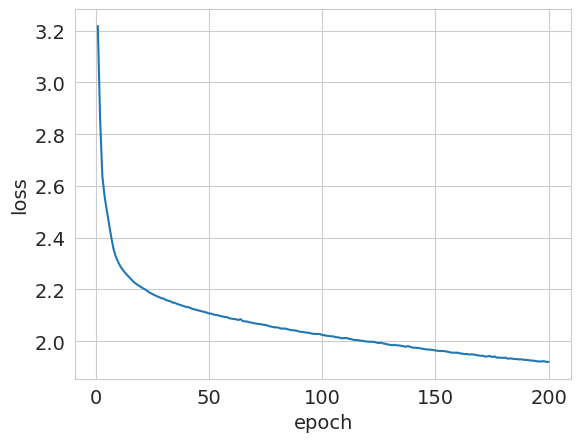

In [ ]:
losses = []
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    model.train()
    for tokens, lengths in dataloader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths - 1)
        # logits: (B, L, V), tokens: (B, L) - need to transpose logits
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tokens.shape[0]

    losses += [running_loss / len(dataset)]

    if epoch % 10 == 0:
        plot_losses(losses)

In [ ]:
# unconditional generation
[model.inference('') for _ in range(10)]

['arount',
 'elerien',
 'eliymor',
 'agaerah',
 'taarae',
 'terym',
 'rialasth',
 'thandaershor',
 'delpendar',
 'trysaan']

In [ ]:
# conditional generation from prefix
[model.inference('an') for _ in range(10)]

['anseril',
 'anlaerith',
 'anoroth',
 'ancern',
 'andallar',
 'anauthraela',
 'anmrylsa',
 'anaelara',
 'anvossan',
 'antor']

# 2. Image captioning

In [ ]:
%%bash
kaggle datasets download -d adityajn105/flickr8k
unzip flickr8k.zip

In [ ]:
import os
import pandas as pd
from PIL import Image

In [ ]:
captions = pd.read_csv('flickr30k_images/results.csv', sep='\|\ ').dropna()
captions

/tmp/ipykernel_17409/311428869.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  captions = pd.read_csv('flickr30k_images/results.csv', sep='\|\ ').dropna()


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ove...
158911,998845445.jpg,1,"A young man hanging over the side of a boat , ..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue and...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with f..."


1: A little boy holding a yellow , plastic shovel , crouches in the sand .
2: A boy wearing a red shirt digs into the sand with a yellow shovel .
3: A little boy squats while playing with a yellow plastic shovel .
4: A little boy in a red shirt and swim trunks plays at the beach .
5: A little boy is kneeling looking at his yellow shovel


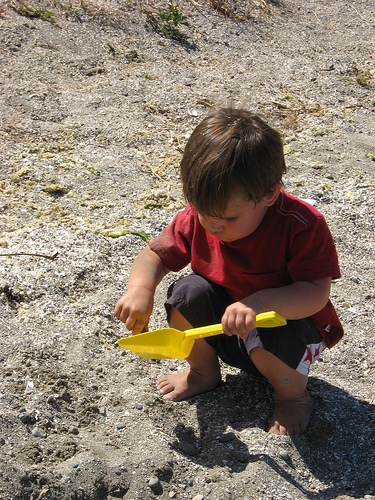

In [ ]:
image_file = captions.image_name.sample(1).iloc[0]
for i, caption in enumerate(captions[captions.image_name == image_file].comment):
    print(f'{i + 1}:', caption)
Image.open(os.path.join('flickr30k_images/flickr30k_images', image_file))

In [ ]:
image_ids = {k: i for i, k in enumerate(captions.image_name.unique())}
image_list = list(map(lambda x: x[0], sorted(image_ids.items(), key=lambda x: x[1])))
captions['image_id'] = captions.image_name.map(image_ids)

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, root, image_list, transform=None):
        super().__init__()
        self.root = root
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, item):
        image_path = os.path.join(self.root, self.image_list[item])
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

cnn_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).eval().to(device)
cnn_model.classifier = nn.Identity()

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImagesDataset(root='flickr30k_images/flickr30k_images', image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, num_workers=4, shuffle=False, batch_size=128)

In [ ]:
image_embeds = []

with torch.no_grad():
    for images in tqdm(dataloader):
        embeds = cnn_model(images.to(device))
        image_embeds += [embeds.cpu()]

image_embeds = torch.cat(image_embeds, dim=0)

  0%|          | 0/249 [00:00<?, ?it/s]

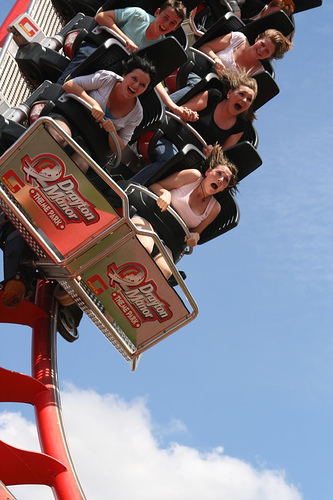

In [ ]:
i = 1001
image = Image.open(f'flickr30k_images/flickr30k_images/{image_list[i]}').convert('RGB')
image

In [ ]:
captions[captions.image_id == 1001]

,image_name,comment_number,comment,image_id
5005,1315116409.jpg,0,A Drayton Manor Theme Park roller coaster is s...,1001
5006,1315116409.jpg,1,The Drayton Manor Theme Park roller coaster on...,1001
5007,1315116409.jpg,2,While everybody else is having fun on a roller...,1001
5008,1315116409.jpg,3,Several people are riding on a roller coaster ...,1001
5009,1315116409.jpg,4,Family of people right before they crash to th...,1001


In [ ]:
image_embeds[i]

tensor([1.1761, 1.1078, 0.2266,  ..., 0.8633, 0.2646, 0.7810])

In [ ]:
cnn_model(transform(image).to(device).unsqueeze(0))

tensor([[1.1761, 1.1078, 0.2266,  ..., 0.8633, 0.2646, 0.7810]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [ ]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_embeds, test_embeds = \
    train_test_split(image_list, image_embeds, test_size=0.25, random_state=42)

train_embeds.shape, test_embeds.shape

(torch.Size([23837, 1280]), torch.Size([7946, 1280]))

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_tensors = []
for image_file in tqdm(image_list):
    image = Image.open(os.path.join('Images', image_file)).convert('RGB')
    image_tensors += [transform(image)]

image_tensors = torch.stack(image_tensors, dim=0)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImagesDataset(root='flickr30k_images/flickr30k_images', image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, num_workers=4, shuffle=False, batch_size=128)

In [ ]:
train_captions = captions[captions.image_name.isin(train_images)]
test_captions = captions[captions.image_name.isin(test_images)]

train_captions.shape, test_captions.shape

((119184, 4), (39730, 4))

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english", language="en")
train_captions['tokens'] = train_captions.comment.apply(tokenizer)
test_captions['tokens'] = test_captions.comment.apply(tokenizer)

specials = ['<pad>', '<bos>', '<eos>', '<unk>']
vocab = build_vocab_from_iterator(train_captions.tokens, specials=specials, min_freq=5)
itos = vocab.get_itos()

PAD_IDX, BOS_IDX, EOS_IDX, UNK_IDX = vocab['<pad>'], vocab['<bos>'], vocab['<eos>'], vocab['<unk>']
vocab.set_default_index(UNK_IDX)
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

/tmp/ipykernel_17409/90248700.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_captions['tokens'] = train_captions.comment.apply(tokenizer)
/tmp/ipykernel_17409/90248700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_captions['tokens'] = test_captions.comment.apply(tokenizer)


6829

Train max length: 79


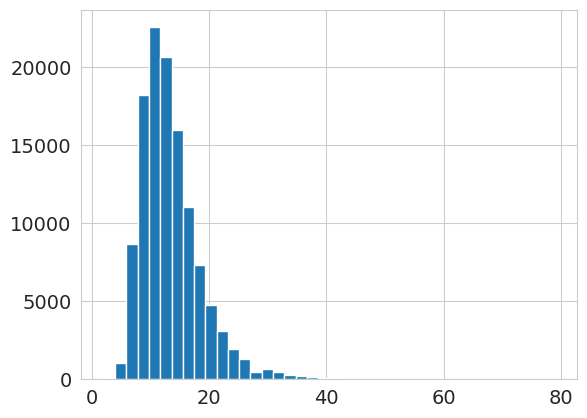

In [ ]:
print('Train max length:', train_captions.tokens.apply(len).max())
plt.hist(train_captions.tokens.apply(len), bins=40)
MAX_LENGTH = 40
plt.show()

In [ ]:
train_captions

,image_name,comment_number,comment,image_id,tokens
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0,"[two, young, guys, with, shaggy, hair, look, a..."
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0,"[two, young, ,, white, males, are, outside, ne..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0,"[two, men, in, green, shirts, are, standing, i..."
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0,"[a, man, in, a, blue, shirt, standing, in, a, ..."
4,1000092795.jpg,4,Two friends enjoy time spent together .,0,"[two, friends, enjoy, time, spent, together, .]"
...,...,...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ove...,31782,"[a, man, in, shorts, and, a, hawaiian, shirt, ..."
158911,998845445.jpg,1,"A young man hanging over the side of a boat , ...",31782,"[a, young, man, hanging, over, the, side, of, ..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue and...,31782,"[a, man, is, leaning, off, of, the, side, of, ..."
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with f...",31782,"[a, man, riding, a, small, boat, in, a, harbor..."


In [ ]:
class CaptionsDataset(Dataset):
    def __init__(self, tokens, embeds):
        super().__init__()
        self.tokens = tokens
        self.embeds = embeds

    def __len__(self):
        return len(self.tokens)

    def tokens_to_idx(self, tokens):
        return [vocab[token] for token in tokens]

    def idx_to_tokens(self, idx):
        return [itos[index] for index in idx]

    def encode(self, tokens):
        tokens = ['<bos>'] + tokens + ['<eos>']
        return self.tokens_to_idx(tokens)

    def decode(self, idx):
        tokens = self.idx_to_tokens(idx)
        return ' '.join(token for token in tokens if token not in specials)

    def __getitem__(self, item):
        tokens = self.tokens.iloc[item].tokens
        encoded = self.encode(tokens)[:MAX_LENGTH + 2]
        padded = torch.full((MAX_LENGTH + 2, ), PAD_IDX, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)

        image_id = self.tokens.iloc[item].image_id
        return padded, len(encoded), self.embeds[image_id]

In [ ]:
train_set = CaptionsDataset(train_captions, image_embeds)
test_set = CaptionsDataset(test_captions, image_embeds)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
embeds_loader = DataLoader(test_embeds, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
captions_list = []

for image in tqdm(test_images):
    data = test_captions[test_captions.image_name == image]
    captions_list += [data.comment.str.lower().tolist()]

  0%|          | 0/7946 [00:00<?, ?it/s]

In [ ]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


class CaptionRNN(nn.Module):
    def __init__(self, image_embed_dim, embed_dim=256, hidden_dim=256, lstm_layers=1, dropout=0.1):
        super().__init__()
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.image_embed_to_h0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )

        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=embed_dim,
                                      padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, VOCAB_SIZE)
        )

    def forward(self, tokens, lengths, image_embeds):
        '''
        B - batch size
        M - lstm layers
        L - sequence length
        I - image embedding dim
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # image_embeds: (B, I)
        B = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        # h0, co: (M, B, H)

        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form

        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, (h, c) = self.lstm(packed_embeds, (h0, c0))
        # output: (B, L, H) in packed form, (h, c): (M, B, H)
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, image_embeds):
        self.eval()
        # generate lstm input
        B = image_embeds.shape[0]
        h = self.image_embed_to_h0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        h, c = h.contiguous(), c.contiguous()

        # init tokens with <bos>
        tokens = torch.full((B, 1), BOS_IDX, device=image_embeds.device)
        new_tokens = tokens

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < MAX_LENGTH:
            if ((tokens == EOS_IDX).sum(1) > 0).all():
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, (h, c) = self.lstm(embeds, (h, c))
            logits = self.linear(output)

            # get new tokens from logits
            new_tokens = logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)

        return tokens

In [ ]:
# testing
model = CaptionRNN(image_embeds.shape[1])

for tokens, lengths, embeds in train_loader:
    break

tokens = tokens[:, :lengths.max()]
logits = model(tokens, lengths, embeds)
assert logits.shape == (tokens.shape[0], tokens.shape[1], VOCAB_SIZE)

tokens = model.inference(embeds)
train_set.decode(tokens[0])

'competition controls wheels holes christian spar doing euro evening watering long-sleeved t-shirt puppet fellow rodgers soldier mower exits meets caged bigger resting shocked shocked surveying border dinner lights admire ski strainer hero playing socialize what snowbank injured celebrating beanbag'

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
import numpy as np


BLEU_FREQ = 5


def plot_losses(train_losses, test_losses, test_blues):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(BLEU_FREQ * np.arange(1, len(test_blues) + 1), test_blues, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('BLEU')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
from torchmetrics import BLEUScore


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    for tokens, lengths, embeds in tqdm(train_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        optimizer.zero_grad()
        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for tokens, lengths, embeds in tqdm(valid_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])

        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss


def evaluate_bleu(model, embeds_loader, captions):
    bleu = BLEUScore()
    predictions = []
    model.eval()
    for embeds in tqdm(embeds_loader, desc='Evaluating BLEU'):
        tokens = model.inference(embeds.to(device)).cpu()
        for token_list in tokens:
            predictions += [train_set.decode(token_list)]

    return bleu(predictions, captions).item()


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader,
          embeds_loader, captions_list, num_epochs):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % BLEU_FREQ == 0:
            valid_bleu = evaluate_bleu(model, embeds_loader, captions_list)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

In [ ]:
NUM_EPOCHS = 20

model = CaptionRNN(image_embeds.shape[1], dropout=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = None
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

sum(param.numel() for param in model.parameters())

4685485

In [ ]:
print(f'Random BLEU: {evaluate_bleu(model, embeds_loader, captions_list):.4f}')

Evaluating BLEU:   0%|          | 0/63 [00:00<?, ?it/s]

Random BLEU: 0.0000


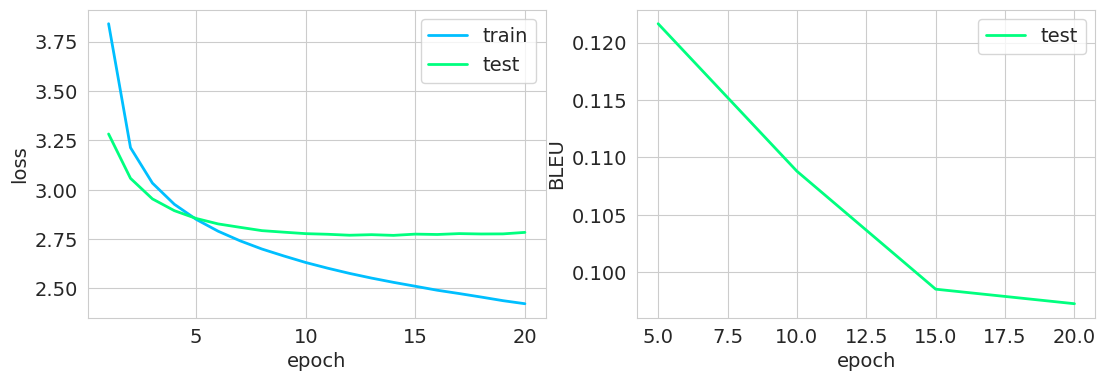

In [ ]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader,
      embeds_loader, captions_list, NUM_EPOCHS)

In [ ]:
def caption_random_test_image():
    index = np.random.randint(len(test_images))
    image_file = test_images[index]
    tokens = model.inference(image_embeds[index].unsqueeze(0).to(device)).cpu().squeeze()
    prediction = train_set.decode(tokens)
    print('Prediction:', prediction)

    for i, caption in enumerate(captions[captions.image_name == image_file].comment):
        print(f'GT caption #{i + 1}:', caption)

    return Image.open(os.path.join('flickr30k_images/flickr30k_images', image_file)).convert('RGB')

Prediction: a woman in a pink shirt is standing in front of a large pile of hay .
GT caption #1: A guy in a yellow parachute jumpsuit is standing between a row of packed parachutes .
GT caption #2: A man in a yellow jumpsuit is standing outside next to brown bags on the ground .
GT caption #3: A man in a yellow jumpsuit stands next to parachuting equipment .
GT caption #4: Protective padding at the ready for some type of gearing up .
GT caption #5: A man in a yellow suit is standing front of the crowd .


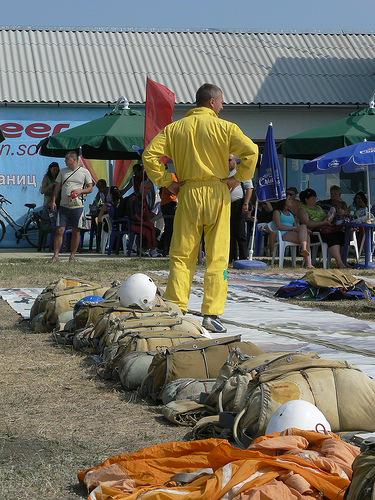

In [ ]:
caption_random_test_image()